In [1]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt

In [2]:
def Wendland(R, S):
  if (R <= S):
    r = R / S
    return (1.0 - r) * (1.0 - r) * (1.0 - r) * (1.0 - r) * (4.0 * r + 1.0) #((21.0 / (2.0 * np.pi * S * S * S)) * (1.0 - r) * (1.0 - r) * (1.0 - r) * (1.0 - r) * (4.0 * r + 1.0))
  else:
    return 0.0

In [3]:
def AveragedTransientStokeslet(h, nut):
  return (1.0 / (4.0 * np.pi * h) - np.sqrt(nut / np.pi) * np.exp(-h * h / (4.0 * nut)) / (2.0 * np.pi * h * h) - (h * h - 2.0 * nut) * special.erf(h / (2.0 * np.sqrt(nut))) / (4.0 * np.pi * h * h * h))
def H1Transient(r, nut):
  return ((1.0 / (8.0 * np.pi * r)) * (1.0 + (2.0 / r) * np.sqrt(nut / np.pi) * np.exp(-r * r / (4.0 * nut)) - (1.0 + 2.0 * nut / (r * r)) * special.erf(r / np.sqrt(4.0 * nut))))
def H2Transient(r, nut):
  return ((1.0 / (8.0 * np.pi * r * r * r)) * (1.0 - (6.0 / r) * np.sqrt(nut / np.pi) * np.exp(-r * r / (4.0 * nut)) - (1.0 - 6.0 * nut / (r * r)) * special.erf(r / np.sqrt(4.0 * nut))))
def H1Normalized(r, t):
  return (1.0 / (8.0 * np.pi * r)) * (1.0 + (2.0 / r) * np.sqrt(t / np.pi) * np.exp(-r * r / (4.0 * t)) - (1.0 + 2.0 * t / (r * r)) * special.erf(r / np.sqrt(4.0 * t)))
def H2Normalized(r, t):
  return (1.0 / (8.0 * np.pi * r * r * r)) * (1.0 - (6.0 / r) * np.sqrt(t / np.pi) * np.exp(-r * r / (4.0 * t)) - (1.0 - 6.0 * t / (r * r)) * special.erf(r / np.sqrt(4.0 * t)))

In [4]:
MaxN = 60 # Max spatial resolution of the map
Factor = 3 # How much larger than the kernel radius is the map
FilterDelta = 1.0
dx = FilterDelta/5
h = dx*(3.0/(4.0*np.pi))**(1/3)
dnut = 1e-3

print(dx)
print(h)

Nk = int(np.ceil(FilterDelta / dx) + 1)
N = Factor * Nk
N = min(MaxN, N)
N = max(Nk, N)
NX = 2 * N + 2 * Nk + 1
NY = 2 * N + 2 * Nk + 1
NZ = 2 * N + 2 * Nk + 1

Ntlog = 25
IncrementFactor = np.log10(2.5) #np.log10(1.1)

0.2
0.12407009817988002


In [5]:
L = (Nk+N)*dx
X = np.linspace(-L, L, NX, endpoint=True)
Y = np.linspace(-L, L, NY, endpoint=True)
Z = np.linspace(-L, L, NZ, endpoint=True)

0.019710697100323037
0.02673434394032531
0.019710697100323037


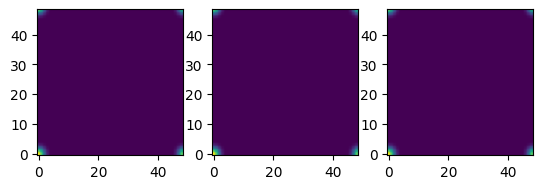

In [6]:
Filter = np.zeros((NX,NY,NZ))
R = np.zeros((NX,NY,NZ))
FilterNorm = 0.0
for i in range(NX):
  for j in range(NY):
    for k in range(NZ):
      R[i][j][k] = np.sqrt(X[i]**2 + Y[j]**2 + Z[k]**2)
      # Filter[(i-Nk-N)%NX][(j-Nk-N)%NY][(k-Nk-N)%NZ] = Wendland(R[i][j][k], FilterDelta)
      Filter[i][j][k] = Wendland(R[i][j][k], FilterDelta)
for i in range(NX):
  for j in range(NY):
    for k in range(NZ):
      # FilterNorm += dx * dx * dx * Filter[i][j][k]
      FilterNorm += Filter[i][j][k]
Filter /= FilterNorm
Filter = np.copy(np.roll(Filter, (N+Nk+1,N+Nk+1,N+Nk+1), axis=(0,1,2)))

print(Filter[0][0][-1])
print(Filter[0][0][0])
print(Filter[0][0][1])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(np.swapaxes(Filter[0,:,:],0,1),origin='lower')#,vmin=np.min(RegStMapXX),vmax=np.max(RegStMapXX))
ax2.imshow(np.swapaxes(Filter[:,0,:],0,1),origin='lower')#,vmin=np.min(RegStMapXX),vmax=np.max(RegStMapXX))
ax3.imshow(np.swapaxes(Filter[:,:,0],0,1),origin='lower')#,vmin=np.min(RegStMapXX),vmax=np.max(RegStMapXX))



In [7]:
FFilter = np.fft.fftn(Filter)

In [8]:
StokesletXX = np.zeros((NX,NY,NZ))
StokesletXY = np.zeros((NX,NY,NZ))
StokesletXZ = np.zeros((NX,NY,NZ))

RegStMapXX = np.zeros((Ntlog,2*N+1,2*N+1,2*N+1))
RegStMapXY = np.zeros((Ntlog,2*N+1,2*N+1,2*N+1))
RegStMapXZ = np.zeros((Ntlog,2*N+1,2*N+1,2*N+1))

nut = 0
times = []
for n in range(Ntlog):
  nut = dnut * 10.0**(float(n)*IncrementFactor)
  times.append(nut)
  print("nu*t = %.2e" % nut)
  for i in range(NX):
    for j in range(NY):
      for k in range(NZ):
        if R[i][j][k] <= h:
          StokesletXX[i][j][k] = AveragedTransientStokeslet(h, nut)
          StokesletXY[i][j][k] = 0.0
          StokesletXZ[i][j][k] = 0.0
        else:
          H1 = H1Transient(R[i][j][k], nut)
          H2 = H2Transient(R[i][j][k], nut)
          StokesletXX[i][j][k] = H1 + H2 * X[i] * X[i]
          StokesletXY[i][j][k] = 0  + H2 * X[i] * Y[j]
          StokesletXZ[i][j][k] = 0  + H2 * X[i] * Z[k]
  FStokesletXX = np.fft.fftn(StokesletXX)
  FStokesletXY = np.fft.fftn(StokesletXY)
  FStokesletXZ = np.fft.fftn(StokesletXZ)
  FRegStokesletXX = np.multiply(FStokesletXX, FFilter)
  FRegStokesletXY = np.multiply(FStokesletXY, FFilter)
  FRegStokesletXZ = np.multiply(FStokesletXZ, FFilter)
  RegStokesletXX = np.fft.ifftn(FRegStokesletXX)
  RegStokesletXY = np.fft.ifftn(FRegStokesletXY)
  RegStokesletXZ = np.fft.ifftn(FRegStokesletXZ)
  for i in range(Nk,Nk+2*N+1):
    for j in range(Nk,Nk+2*N+1):
      for k in range(Nk,Nk+2*N+1):
        RegStMapXX[n][i-Nk][j-Nk][k-Nk] = np.real(RegStokesletXX[i][j][k])      
        RegStMapXY[n][i-Nk][j-Nk][k-Nk] = np.real(RegStokesletXY[i][j][k])        
        RegStMapXZ[n][i-Nk][j-Nk][k-Nk] = np.real(RegStokesletXZ[i][j][k])

nu*t = 1.00e-03
nu*t = 2.50e-03
nu*t = 6.25e-03
nu*t = 1.56e-02
nu*t = 3.91e-02
nu*t = 9.77e-02
nu*t = 2.44e-01
nu*t = 6.10e-01
nu*t = 1.53e+00
nu*t = 3.81e+00
nu*t = 9.54e+00
nu*t = 2.38e+01
nu*t = 5.96e+01
nu*t = 1.49e+02
nu*t = 3.73e+02
nu*t = 9.31e+02
nu*t = 2.33e+03
nu*t = 5.82e+03
nu*t = 1.46e+04
nu*t = 3.64e+04
nu*t = 9.09e+04
nu*t = 2.27e+05
nu*t = 5.68e+05
nu*t = 1.42e+06
nu*t = 3.55e+06


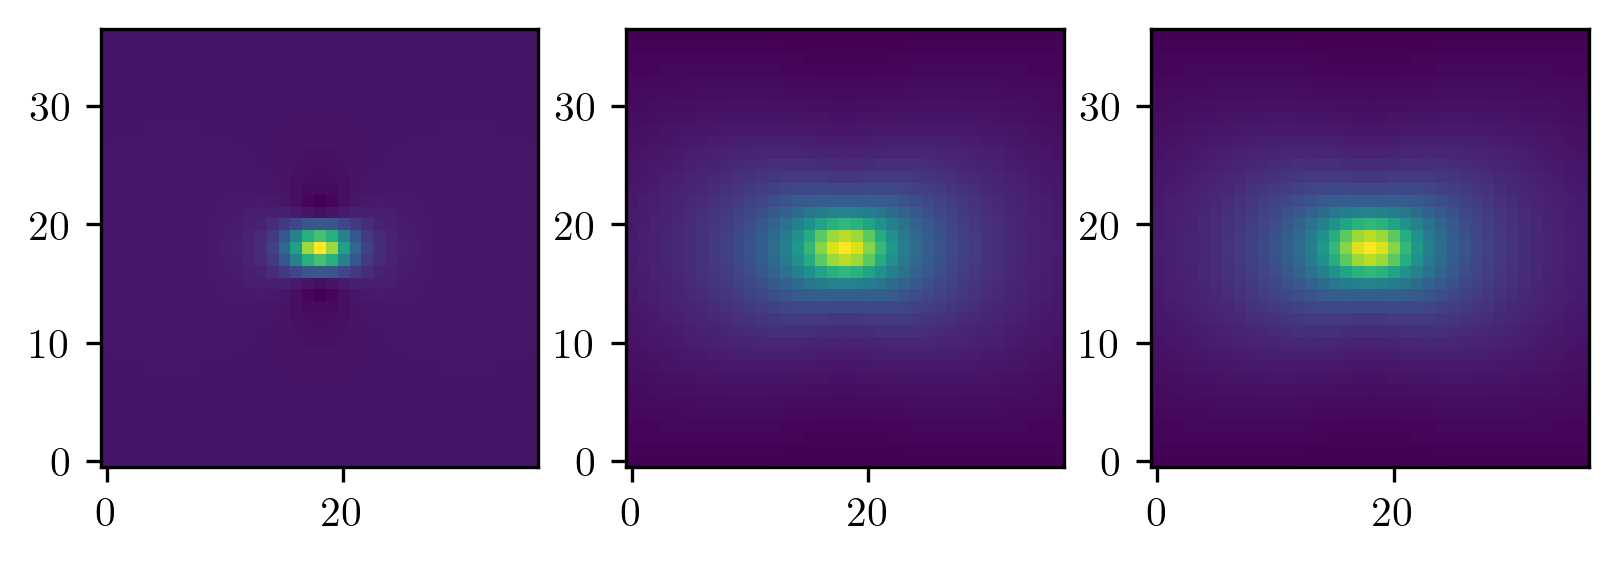

In [9]:
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(np.swapaxes(RegStMapXX[0,:,:,N],0,1),origin='lower')#,vmin=np.min(RegStMapXX),vmax=np.max(RegStMapXX))
ax2.imshow(np.swapaxes(RegStMapXX[int(Ntlog/2),:,:,N],0,1),origin='lower')#,vmin=np.min(RegStMapXX),vmax=np.max(RegStMapXX))
ax3.imshow(np.swapaxes(RegStMapXX[-1,:,:,N],0,1),origin='lower')#,vmin=np.min(RegStMapXX),vmax=np.max(RegStMapXX))

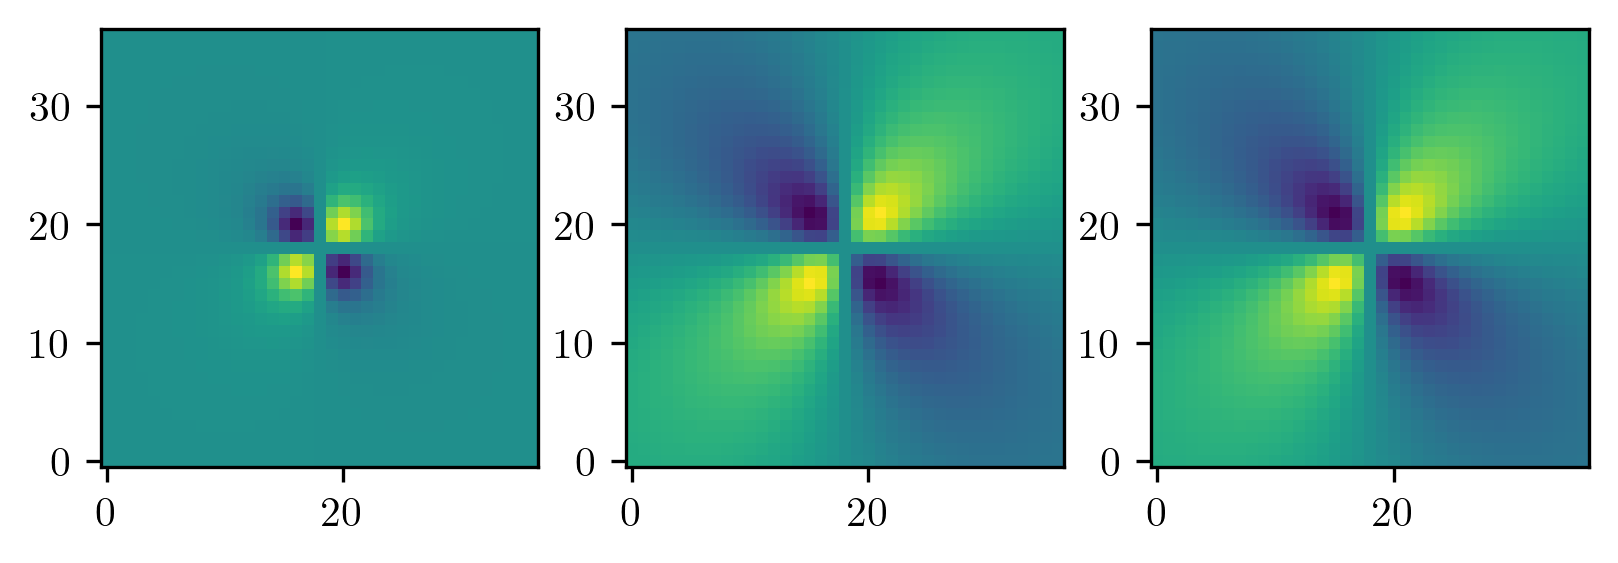

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(np.swapaxes(RegStMapXY[0,:,:,N],0,1),origin='lower')#,vmin=np.min(RegStMapXY),vmax=np.max(RegStMapXY))
ax2.imshow(np.swapaxes(RegStMapXY[int(Ntlog/2),:,:,N],0,1),origin='lower')#,vmin=np.min(RegStMapXY),vmax=np.max(RegStMapXY))
ax3.imshow(np.swapaxes(RegStMapXY[-1,:,:,N],0,1),origin='lower')#,vmin=np.min(RegStMapXY),vmax=np.max(RegStMapXY))

/var/folders/7j/2_f7_p7s4d17vbxw_swr8q600000gn/T/ipykernel_58832/3537718225.py:8: RuntimeWarning: divide by zero encountered in divide
  return (1.0 / (8.0 * np.pi * r)) * (1.0 + (2.0 / r) * np.sqrt(t / np.pi) * np.exp(-r * r / (4.0 * t)) - (1.0 + 2.0 * t / (r * r)) * special.erf(r / np.sqrt(4.0 * t)))
/var/folders/7j/2_f7_p7s4d17vbxw_swr8q600000gn/T/ipykernel_58832/3537718225.py:8: RuntimeWarning: invalid value encountered in multiply
  return (1.0 / (8.0 * np.pi * r)) * (1.0 + (2.0 / r) * np.sqrt(t / np.pi) * np.exp(-r * r / (4.0 * t)) - (1.0 + 2.0 * t / (r * r)) * special.erf(r / np.sqrt(4.0 * t)))
/var/folders/7j/2_f7_p7s4d17vbxw_swr8q600000gn/T/ipykernel_58832/3537718225.py:10: RuntimeWarning: divide by zero encountered in divide
  return (1.0 / (8.0 * np.pi * r * r * r)) * (1.0 - (6.0 / r) * np.sqrt(t / np.pi) * np.exp(-r * r / (4.0 * t)) - (1.0 - 6.0 * t / (r * r)) * special.erf(r / np.sqrt(4.0 * t)))
/var/folders/7j/2_f7_p7s4d17vbxw_swr8q600000gn/T/ipykernel_58832/3537718225.py

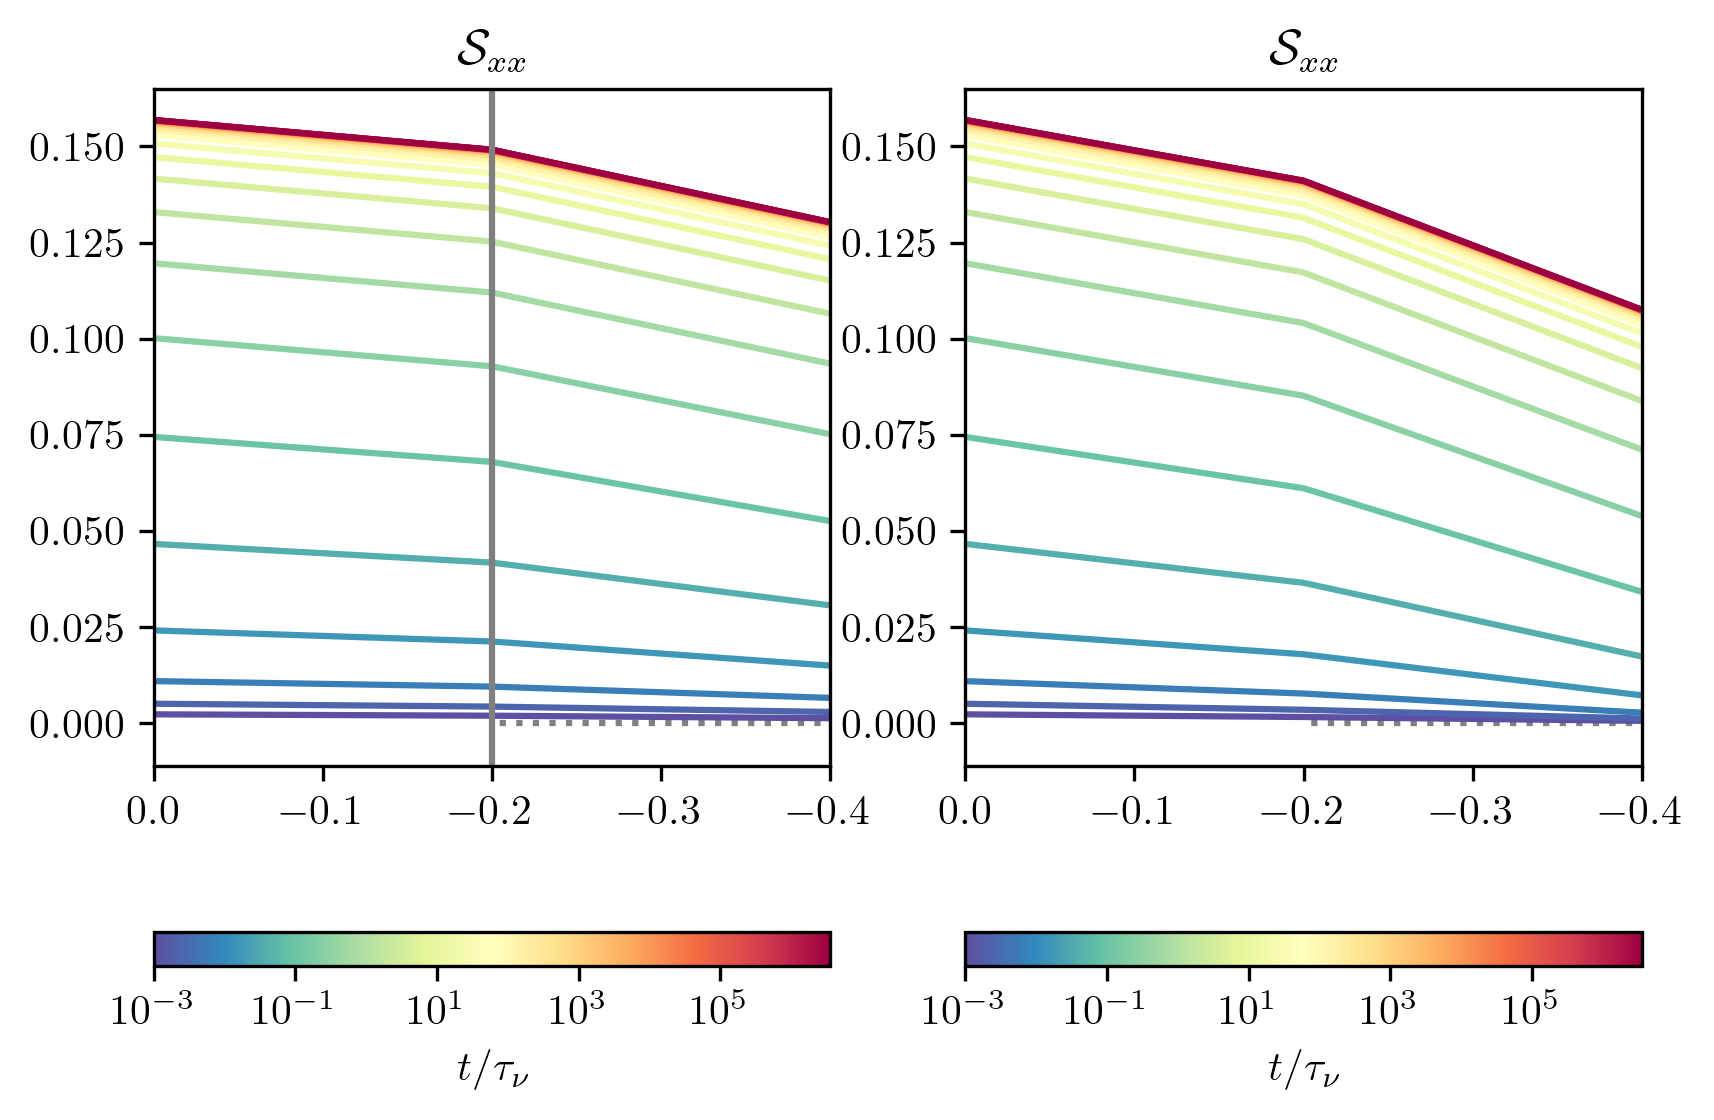

In [11]:
import matplotlib as mpl 
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

junction = X[N+Nk-1]
total = 2*junction

fig, (ax1, ax2) = plt.subplots(1,2)
fmin = np.min(RegStMapXX)
fmax = np.max(RegStMapXX)
margin = 0.05*(fmax-fmin)
ax1.set_xlim(0,total)
ax1.set_ylim(-margin+np.min(RegStMapXX),margin+np.max(RegStMapXX))
ax2.set_xlim(0,total)
ax2.set_ylim(-margin+np.min(RegStMapXX),margin+np.max(RegStMapXX))
ax1.plot(X[Nk:(N+Nk)],np.zeros(N),color="gray",linestyle='dotted')
ax2.plot(X[Nk:(N+Nk)],np.zeros(N),color="gray",linestyle='dotted')
x = X[Nk:(2*N+1+Nk)]
x1 = X[(Nk+1):(2*N+1+Nk)]
x2 = np.linspace(junction, total, 100, endpoint=True)
for n in range(Ntlog):
  t = times[n]
  ax1.plot(x,RegStMapXX[n,:,N,N],color=plt.cm.Spectral_r(n/(Ntlog-1)))
  ax1.plot(x1,H1Normalized(x1,t)*np.ones(len(x1))+H2Normalized(x1,t)*x1*x1,color=plt.cm.Spectral_r(n/(Ntlog-1)),alpha=0.2)
  ax1.plot(x2,H1Normalized(x2,t)*np.ones(100)+H2Normalized(x2,t)*x2*x2,color=plt.cm.Spectral_r(n/(Ntlog-1)),linestyle='dotted')
  ax2.plot(Y[Nk:(2*N+1+Nk)],RegStMapXX[n,N,:,N],color=plt.cm.Spectral_r(n/(Ntlog-1)))
  ax2.plot(x1,H1Normalized(x1,t)*np.ones(len(x1)),color=plt.cm.Spectral_r(n/(Ntlog-1)),alpha=0.2)
  ax2.plot(x2,H1Normalized(x2,t)*np.ones(100),color=plt.cm.Spectral_r(n/(Ntlog-1)),linestyle='dotted')
ax1.plot([junction,junction],[-1e6,1e6],color="gray",linestyle='solid')
ax1.set_title(r'$\mathcal{S}_{xx}$')
ax2.set_title(r'$\mathcal{S}_{xx}$')
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high)))
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high)))
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(dnut,nut), cmap='Spectral_r'), ax=ax1, orientation='horizontal', label=r'$t/\tau_\nu$')
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(dnut,nut), cmap='Spectral_r'), ax=ax2, orientation='horizontal', label=r'$t/\tau_\nu$')


In [12]:
with open('maps3d_X.npy', 'wb') as f:
    np.save(f, x)
with open('maps3d_logT.npy', 'wb') as f:
    np.save(f, np.log10(times))
with open('maps3d_Sxx.npy', 'wb') as f:
    np.save(f, RegStMapXX)
with open('maps3d_Sxy.npy', 'wb') as f:
    np.save(f, RegStMapXY)
with open('maps3d_Sxz.npy', 'wb') as f:
    np.save(f, RegStMapXZ)
    